In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from minGPT.mingpt import model
# make deterministic
from minGPT.mingpt.utils import set_seed
set_seed(42)
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [2]:

randomVars = torch.rand([10, 5])
# [i,j] represents transition pr from node i to node j
# so each row needs to sum to 1
randomVars = randomVars/randomVars.sum(axis=1, keepdim=True) # Sum along each row, keep dim so it projects along the right axis
# Double check
assert(torch.allclose(randomVars.sum(axis=1), torch.ones([10]), 0.001)) 

## Code that ensures zero rows get set to the corredct values
a = torch.rand([4, 5])
a[0,:] = 0
a[3,:] = 0
a
rowSums = a.sum(axis=1, keepdim=True)
a[(rowSums==0).flatten()] = 1.0
a


weights = torch.tensor([0, 10, 3, 0], dtype=torch.float)
torch.multinomial(torch.tensor([0.0, 0.2, 0.8]), 100, replacement=True)

a = HMM(3, 4)
a.transitionMatrix, a.emitMatrix
b = torch.tensor([1])
print(a.transitionMatrix[b].flatten().argmax())

a.generate(10)

NameError: name 'HMM' is not defined

In [2]:


from torch.utils.data import Dataset
class AutomataDataset(Dataset):
    def __init__(self, automata, split, sequenceLen, numSequences):
        self.hmm = automata
        self.split = split # train/test
        self.vocab_size = len(automata.symbols)
        # +1 due to potential carry overflow, but then -1 because very last digit doesn't plug back
        self.block_size = sequenceLen
        
        self.sequenceLen, self.numSequences = sequenceLen, numSequences
        
        '''
        # split up all addition problems into either training data or test data
        num = (10**self.ndigit)**2 # total number of possible combinations
        r = np.random.RandomState(1337) # make deterministic
        perm = r.permutation(num)
        num_test = min(int(num*0.2), 1000) # 20% of the whole dataset, or only up to 1000
        self.ixes = perm[:num_test] if split == 'test' else perm[num_test:]
        '''


    def __len__(self):
        return self.numSequences

    def __getitem__(self, idx):
        
        X, Y = self.hmm.generate(self.sequenceLen)
        x = torch.tensor(X)
        y = torch.tensor(Y) # predict the output of the Automata
        return x, y
        
        '''
        # given a problem index idx, first recover the associated a + b
        idx = self.ixes[idx]
        nd = 10**self.ndigit
        a = idx // nd
        b = idx %  nd
        c = a + b
        render = f'%0{self.ndigit}d%0{self.ndigit}d%0{self.ndigit+1}d' % (a,b,c) # e.g. 03+25=28 becomes "0325028" 
        dix = [int(s) for s in render] # convert each character to its token index
        # x will be input to GPT and y will be the associated expected outputs
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long) # predict the next token in the sequence
        y[:self.ndigit*2-1] = -100 # we will only train in the output locations. -100 will mask loss to zero
        return x, y
        '''


In [3]:




from torch.utils.data import Dataset

# ensures sum of rows is 1.0.
# if any rows are all zeros, it sets them to uniform distr (all values are 1.0/length of row)
# assumes input values are between 0.0 and 1.0, probably generated by torch.rand
def normalizeRows(mat):
    rowSums = mat.sum(axis=1, keepdim=True)
    mat[(rowSums==0).flatten()] = 1.0 # any rows that are all zero get set to uniform distr to prevent divide by zero and ensure good probabilities
    rowSums = mat.sum(axis=1, keepdim=True)
    return mat/rowSums

def sampleRow(row):
    return torch.multinomial(row.flatten(), 1, replacement=True)
def sampleRowDeterministic(row):
    return row.flatten().argmax()

class HMM(object):
    def __init__(self, nNodes, nSymbols, randomizeFirstState=True):
        self.nNodes, self.nSymbols, self.randomizeFirstState = nNodes, nSymbols, randomizeFirstState
        # self.transitionMatrix[i,j] is pr of going from node i to node j
        # thus, [i,0] + [i,1] + ... + [i,n-1] = 1
        # so each row needs to sum to 1
        self.transitionMatrix = normalizeRows(torch.rand([nNodes, nNodes]))
        # self.emitMatrix[i,j] is pr of node i emitting symbol j
        # thus, [i,0] + [i,1] + ...  [i,n-1] = 1
        # so each row needs to sum to 1
        self.emitMatrix = normalizeRows(torch.rand([nNodes, nSymbols]))
        # Todo: initial distr on initial nodes
        
    def generate(self, nTokens):
        if self.randomizeFirstState:
            curState = torch.randint(0, self.nNodes, [1])
        else:
            curState = torch.tensor([0])
        result = []
        for i in range(nTokens):
            result.append(sampleRowDeterministic(self.emitMatrix[curState]))
            curState = sampleRowDeterministic(self.transitionMatrix[curState])
        return torch.tensor(result)

        
    
        
    def test(self):
        # Check that rows are roughly summing to 1.0
        assert(torch.allclose(self.transitionMatrix.sum(axis=1), torch.ones([self.nSymbols]), 0.001))

class HMMDataset(Dataset):
    def __init__(self, hmm, split, sequenceLen, numSequences):
        self.hmm = hmm
        self.split = split # train/test
        self.ndigit = ndigit
        self.vocab_size = hmm.nSymbols
        # +1 due to potential carry overflow, but then -1 because very last digit doesn't plug back
        self.block_size = sequenceLen
        
        self.sequenceLen, self.numSequences = sequenceLen, numSequences
        
        '''
        # split up all addition problems into either training data or test data
        num = (10**self.ndigit)**2 # total number of possible combinations
        r = np.random.RandomState(1337) # make deterministic
        perm = r.permutation(num)
        num_test = min(int(num*0.2), 1000) # 20% of the whole dataset, or only up to 1000
        self.ixes = perm[:num_test] if split == 'test' else perm[num_test:]
        '''


    def __len__(self):
        return self.numSequences

    def __getitem__(self, idx):
        
        data = self.hmm.generate(self.sequenceLen)
        x = data[:-1]
        y = data[1:] # predict the next token in the sequence
        return x, y
        
        '''
        # given a problem index idx, first recover the associated a + b
        idx = self.ixes[idx]
        nd = 10**self.ndigit
        a = idx // nd
        b = idx %  nd
        c = a + b
        render = f'%0{self.ndigit}d%0{self.ndigit}d%0{self.ndigit+1}d' % (a,b,c) # e.g. 03+25=28 becomes "0325028" 
        dix = [int(s) for s in render] # convert each character to its token index
        # x will be input to GPT and y will be the associated expected outputs
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long) # predict the next token in the sequence
        y[:self.ndigit*2-1] = -100 # we will only train in the output locations. -100 will mask loss to zero
        return x, y
        '''


class AdditionDataset(Dataset):
    """
    Returns addition problems of up to some number of digits in the inputs. Recall
    that all GPT cares about are sequences of integers, and completing them according to
    patterns in the data. Therefore, we have to somehow encode addition problems
    as a sequence of integers.
    
    The sum of two n-digit numbers gives a third up to (n+1)-digit number. So our
    encoding will simply be the n-digit first number, n-digit second number, 
    and (n+1)-digit result, all simply concatenated together. Because each addition
    problem is so structured, there is no need to bother the model with encoding
    +, =, or other tokens. Each possible sequence has the same length, and simply
    contains the raw digits of the addition problem.
    
    As a few examples, the 2-digit problems:
    - 85 + 50 = 135 becomes the sequence [8, 5, 5, 0, 1, 3, 5]
    - 6 + 39 = 45 becomes the sequence [0, 6, 3, 9, 0, 4, 5]
    etc.
    
    We will also only train GPT on the final (n+1)-digits because the first
    two n-digits are always assumed to be given. So when we give GPT an exam later,
    we will e.g. feed it the sequence [0, 6, 3, 9], which encodes that we'd like
    to add 6 + 39, and hope that the model completes the integer sequence with [0, 4, 5]
    in 3 sequential steps.
    
    fun exercise: does it help if the result is asked to be produced in reverse order?
    """

    def __init__(self, ndigit, split):
        self.split = split # train/test
        self.ndigit = ndigit
        self.vocab_size = 10 # 10 possible digits 0..9
        # +1 due to potential carry overflow, but then -1 because very last digit doesn't plug back
        self.block_size = ndigit + ndigit + ndigit + 1 - 1
        
        # split up all addition problems into either training data or test data
        num = (10**self.ndigit)**2 # total number of possible combinations
        r = np.random.RandomState(1337) # make deterministic
        perm = r.permutation(num)
        num_test = min(int(num*0.2), 1000) # 20% of the whole dataset, or only up to 1000
        self.ixes = perm[:num_test] if split == 'test' else perm[num_test:]

    def __len__(self):
        return self.ixes.size

    def __getitem__(self, idx):
        # given a problem index idx, first recover the associated a + b
        idx = self.ixes[idx]
        nd = 10**self.ndigit
        a = idx // nd
        b = idx %  nd
        c = a + b
        render = f'%0{self.ndigit}d%0{self.ndigit}d%0{self.ndigit+1}d' % (a,b,c) # e.g. 03+25=28 becomes "0325028" 
        dix = [int(s) for s in render] # convert each character to its token index
        # x will be input to GPT and y will be the associated expected outputs
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long) # predict the next token in the sequence
        y[:self.ndigit*2-1] = -100 # we will only train in the output locations. -100 will mask loss to zero
        return x, y

Complexity of automata: 1


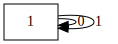

In [4]:
# create a dataset for e.g. 2-digit addition
#ndigit = 3
#train_dataset = AdditionDataset(ndigit=ndigit, split='train')
#test_dataset = AdditionDataset(ndigit=ndigit, split='test')

#hmm = HMM(nNodes=10, nSymbols=3, randomizeFirstState=False)
#train_dataset = HMMDataset(hmm=hmm, split='train', sequenceLen=20, numSequences=100000)
#test_dataset = HMMDataset(hmm=hmm, split='test', sequenceLen=20, numSequences=100000)
import automataBattle
set_seed(27)
a = automataBattle.Automata(nStates=3, symbols=range(2), randomConnect=True)
a.minimize()
print("Complexity of automata:", a.complexity())
train_dataset = AutomataDataset(automata=a, split='train', sequenceLen=50, numSequences=100000)
test_dataset = AutomataDataset(automata=a, split='test', sequenceLen=50, numSequences=10000)
a.toDot()

In [34]:
train_dataset[0] # sample a training instance just to see what one raw example looks 
train_dataset[2]

(tensor([1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
         1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
         1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
         1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
         0, 0, 0, 1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]))

In [16]:
from minGPT.mingpt.model import GPT, GPTConfig, GPT1Config

# initialize a baby GPT model
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size, 
                  n_layer=2, n_head=4, n_embd=256)
model = GPT(mconf)

10/19/2020 19:08:52 - INFO - minGPT.mingpt.model -   number of parameters: 1.593856e+06


In [19]:

import minGPT
from importlib import reload
reload(minGPT.mingpt.model)
from minGPT.mingpt.model import GPT, GPTConfig, GPT1Config


# initialize a baby GPT model
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size, 
                  n_layer=4, n_head=8, n_embd=512)
model = GPT(mconf)

10/19/2020 19:09:04 - INFO - minGPT.mingpt.model -   number of parameters: 1.263821e+07


In [20]:


from minGPT.mingpt.trainer import Trainer, TrainerConfig
def trainAutomata(automata, model, epochs):
    # initialize a trainer instance and kick off training
    tconf = TrainerConfig(max_epochs=epochs, batch_size=2048, learning_rate=6e-5,
                          lr_decay=True, warmup_tokens=2048, final_tokens=50*len(train_dataset)*(2+1),
                          num_workers=1)
    trainer = Trainer(model, train_dataset, test_dataset, tconf)
    trainer.train()
    
set_seed(27)
for i in range(10):
    a = automataBattle.Automata(nStates=3, symbols=range(2), randomConnect=True)
    a.minimize()
    while a.complexity() != 3:
        a = automataBattle.Automata(nStates=3, symbols=range(2), randomConnect=True)
        a.minimize()
    train_dataset = AutomataDataset(automata=a, split='train', sequenceLen=50, numSequences=3000000)
    test_dataset = AutomataDataset(automata=a, split='test', sequenceLen=50, numSequences=10000)
    trainAutomata(a, model, 1)

epoch 1 iter 4: train loss 0.64715. lr 5.999981e-05:   0%|          | 5/1465 [00:01<07:15,  3.35it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5131157160>
Traceback (most recent call last):
  File "/home/phylliida/miniconda3/envs/sandbox1/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/home/phylliida/miniconda3/envs/sandbox1/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/phylliida/miniconda3/envs/sandbox1/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
epoch 1 iter 947: train loss 0.06468. lr 5.337048e-05:  65%|██████▍   | 948/1465 [03:43<02:01,  4.24it/s]


KeyboardInterrupt: 

In [ ]:
ckpt_path = "juniper_1"
raw_model = model.module if hasattr(model, "module") else model
logger.info("saving %s", ckpt_path)
torch.save(raw_model.state_dict(), ckpt_path)

In [22]:
# now let's give the trained model an addition exam
from torch.utils.data.dataloader import DataLoader
from minGPT.mingpt.utils import sample

def give_exam(dataset, batch_size=32, max_batches=-1):
    
    results = []
    loader = DataLoader(dataset, batch_size=batch_size)
    for b, (x, y) in enumerate(loader):
        x = x.to(trainer.device)
        d1d2 = x[:, :ndigit*2]
        d1d2d3 = sample(model, d1d2, ndigit+1)
        d3 = d1d2d3[:, -(ndigit+1):]
        factors = torch.tensor([[10**i for i in range(ndigit+1)][::-1]]).to(trainer.device)
        # decode the integers from individual digits
        d1i = (d1d2[:,:ndigit] * factors[:,1:]).sum(1)
        d2i = (d1d2[:,ndigit:ndigit*2] * factors[:,1:]).sum(1)
        d3i_pred = (d3 * factors).sum(1)
        d3i_gt = d1i + d2i
        correct = (d3i_pred == d3i_gt).cpu() # Software 1.0 vs. Software 2.0 fight RIGHT on this line, lol
        for i in range(x.size(0)):
            results.append(int(correct[i]))
            judge = 'YEP!!!' if correct[i] else 'NOPE'
            if not correct[i]:
                print("GPT claims that %03d + %03d = %03d (gt is %03d; %s)" 
                      % (d1i[i], d2i[i], d3i_pred[i], d3i_gt[i], judge))
        
        if max_batches >= 0 and b+1 >= max_batches:
            break

    print("final score: %d/%d = %.2f%% correct" % (np.sum(results), len(results), 100*np.mean(results)))

In [23]:
# training set: how well did we memorize?
give_exam(train_dataset, batch_size=1024, max_batches=10)

final score: 9000/9000 = 100.00% correct


In [24]:
# test set: how well did we generalize?
give_exam(test_dataset, batch_size=1024, max_batches=-1)

final score: 1000/1000 = 100.00% correct
